In [1]:
import pandas as pd
import numpy as np
import glob as glob
import os

import multiprocessing
import re
from rdkit.Chem import rdchem

from subprocess import check_output

import hashlib
import pandas as pd

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network')
import build_tools as wt


# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

# sys.path.insert(0,'/global/homes/b/bpb/repos/carbon_network/blink')

import blink


# Set the display width for pandas columns
pd.set_option('display.max_colwidth', None)
# show more pandas columns
pd.set_option('display.max_columns', 500)


In [2]:
def get_files_from_disk(directory,extension):
    """
    Get on disk with date
    """
    get_with_date = ''.join(['find %s -iname "*%s"' % (directory,extension),' -printf "%Ts SplitThat%p\n"'])
    files = check_output(get_with_date, shell=True)
    files = files.decode('utf-8').splitlines()
    files = [f.split('SplitThat') for f in files]
    dates = [int(f[0].strip()) for f in files]
    files = [f[1].strip() for f in files]
    return dates,files

half_precursor_tolerance = 0.001 # since we typically use 0.002 as the precursor tolerance, we can use 0.001 as the half tolerance

data_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
metadata_folder = '/global/cfs/cdirs/metatlas/projects/carbon_network'
environmental_metatlas_folder = os.path.join(data_dir,'metatlas')
metatlas_no_buddy_folder = os.path.join(data_dir,'metatlas_no_buddy')


# Get metatlas-no-buddy  files
dates, parquet_files = get_files_from_disk(metatlas_no_buddy_folder, 'parquet')
dates, h5_files = get_files_from_disk(metatlas_no_buddy_folder, 'h5')

df = {}
for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f

# Get metatlas environmental files
dates, parquet_files = get_files_from_disk(environmental_metatlas_folder, 'parquet')
dates, h5_files = get_files_from_disk(environmental_metatlas_folder, 'h5')

for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f

# get massive files
dates, parquet_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'parquet')
dates, h5_files = get_files_from_disk(os.path.join(data_dir,'massive'), 'h5')
for f in parquet_files:
    df[f.replace('.parquet','')] = {}
for f in h5_files:
    df[f.replace('.h5','')] = {}

for f in parquet_files:
    df[f.replace('.parquet','')]['parquet'] = f
for f in h5_files:
    df[f.replace('.h5','')]['h5'] = f


for k,v in df.items():
    if environmental_metatlas_folder in k:
        df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])

for k,v in df.items():
    if metatlas_no_buddy_folder in k:
        df[k]['experiment_id'] = '_'.join(os.path.basename(k).split('_')[4:6])    

df = pd.DataFrame(df).T

# extract the massive ID from the path
pattern = r'(?<=/)(MSV.*?)(?=/)'
a = df.copy().index.str.extract(pattern)
df['massive_id'] = a[0].tolist()

# extract everything from the massive ID to the filename
pattern = r'(\/MSV.*)' 
df['redu_filename'] = df.copy().index.str.extract(pattern,expand=False)
df['redu_filename'] = df['redu_filename'].str.replace(r'^/', 'f.', regex=True)

# ADD IN EXPERIMENT_ID TO DEAL WITH BOTH MASSIVE AND LBL DATASETS
idx = pd.notna(df['massive_id'])
df.loc[idx,'experiment_id'] = df.loc[idx,'massive_id']

df.reset_index(inplace=True,drop=True)

df_grouped = df.groupby('experiment_id').size().reset_index(name='files_per_experiment')
df = pd.merge(df, df_grouped, on='experiment_id', how='left')




In [3]:
from metatlas.untargeted.tools import get_google_sheet
file_df = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1a')
print(df.shape)
df = df[df['parquet'].isin(file_df['parquet'])]
print(df.shape)

(228485, 6)
(1506, 6)


# merge massive metadata with all files

In [4]:
usecols = ['title','dataset','description','keywords','instrument']
massive_metadata = pd.read_csv(os.path.join(metadata_folder,'massive_metadata_2024.tsv'), sep='\t',usecols=usecols)
massive_metadata.columns = [c.lower() for c in massive_metadata.columns]
df = pd.merge(df,massive_metadata.add_suffix('_massive'),left_on='massive_id',right_on='dataset_massive',how='left')


# Merge REDU Information

In [5]:
redu = pd.read_csv(os.path.join(metadata_folder,'all_sampleinformation.tsv'), sep='\t')
redu['filename'] = redu['filename'].str.replace(r'\.mz(ML|XML)$', '', regex=True)
redu.columns = [c.lower() for c in redu.columns]
df = pd.merge(df,redu.add_suffix('_redu'),left_on='redu_filename',right_on='filename_redu',how='left')


# MERGE in Environmental Experiment List

In [6]:
environmental_metatlas_folder

'/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas'

In [7]:
dom_samples = pd.read_csv(os.path.join(metadata_folder,'dom_public_datasets.csv'),usecols=['dataset'])
dom_samples = pd.Series(dom_samples['dataset'].unique())
df['environmental'] = (df['massive_id'].isin(dom_samples)) | (df['parquet'].str.contains(environmental_metatlas_folder+'/'))
df.shape

(1506, 49)

# Identify Plant files for manuscript

In [8]:
idx1 = df['sampletype_redu'].str.contains('plant',case=False,na=False)
idx2 = df['parquet'].str.contains('20240409_EB_NB_107915-001_PRISM-RtExu_combined-rep1-5_EXP120A_C18-EP_USDAY72349')
df['plant'] = (idx1) | (idx2)


In [9]:
df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df = df[~df['parquet'].str.contains('exctrl',case=False)]
df[df['plant']].to_csv(os.path.join(metadata_folder,'plant_samples.csv'),index=False)
df[df['plant']].to_csv('plant_samples.csv',index=False)

# Filter to either plant or environment

In [10]:
df = df[df['environmental']]
df = df[~df['parquet'].str.contains('Frtlzr',case=False)]
df.shape

(1506, 50)

# remove rows that do not have a parquet file

In [11]:
df = df[pd.notna(df['parquet'])]
df = df[~df['parquet'].str.contains('qc',case=False)]
df = df[~df['parquet'].str.contains('blank',case=False)]
df.shape


(1506, 50)

# remove duplicate files

In [12]:


def hash_dataframe_row(filename):
    cols = ['precursor_mz', 'rt', 'coisolated_precursor_count', 'predicted_formula', 'estimated_fdr']
    try:
        t = pd.read_parquet(filename)
        hash_value = int(hashlib.sha256(pd.util.hash_pandas_object(t[cols], index=True).values).hexdigest(), 16)
        return hash_value
    except:
        print('Error',filename)
        return None

def parallel_hash_dataframe(files):
    with multiprocessing.Pool(20) as pool:
        results = pool.map(hash_dataframe_row, files)
    return results

hash_values = parallel_hash_dataframe(df['parquet'].tolist())
df['hash_value'] = hash_values
df.sort_values(['environmental','files_per_experiment','sampletype_redu'],ascending=False,inplace=True) # True is greater than False
df.drop_duplicates(subset=['hash_value'],keep='first',inplace=True)
print(df.shape)

(1506, 51)


In [13]:
# use natural language processing to parse the column description_massive and categorize each row in df


# Load all MDM spectra and formula from the parquet files

In [14]:


def process_row(parquet_file):
    temp = pd.read_parquet(parquet_file)
    if temp.shape[0]>0:
        temp['parquet'] = parquet_file
        return temp
    



files = df[pd.notna(df['parquet'])]['parquet'].tolist()
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row, files)

all_mdm_df = [o for o in out if o is not None]
all_mdm_df = pd.concat(all_mdm_df)
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df = all_mdm_df[pd.notna(all_mdm_df['mdm_mz_vals'])] # 1132622, 833718
all_mdm_df.reset_index(inplace=True,drop=True)
all_mdm_df.index.name = 'original_index' # you need this later for looking at ms1 evidence
all_mdm_df.reset_index(inplace=True,drop=False)
all_mdm_df.shape

(777327, 13)

# Count the fraction of formulae observed in FTICR experiments

environment_type
extraction_solvent
ppl_extracted
instrument_type
mass_range
doi


(array([ 1.,  1.,  1.,  3.,  1.,  3.,  4.,  1.,  5.,  2.,  2.,  0.,  4.,
         7.,  4.,  3.,  3.,  4.,  2.,  5.,  6.,  6.,  2.,  4.,  4.,  1.,
         6.,  6.,  3.,  6.,  4.,  5.,  5., 10.,  6., 12.,  7.,  5.,  5.,
         8., 12.,  6., 12., 16., 12., 20., 10., 18., 12., 15., 12., 26.,
        22., 14., 19., 29., 29., 24., 29., 26., 23., 25., 22., 41., 37.,
        51., 38., 41., 45., 57., 50., 51., 50., 36., 46., 28., 26., 21.,
        24., 17., 18., 26., 20., 15., 16., 16., 13., 13., 13., 15., 13.,
        15., 13., 12., 12.,  6.,  1.,  2.,  4.,  4.]),
 array([0.42696629, 0.43251258, 0.43805887, 0.44360516, 0.44915144,
        0.45469773, 0.46024402, 0.46579031, 0.4713366 , 0.47688288,
        0.48242917, 0.48797546, 0.49352175, 0.49906804, 0.50461432,
        0.51016061, 0.5157069 , 0.52125319, 0.52679948, 0.53234576,
        0.53789205, 0.54343834, 0.54898463, 0.55453092, 0.5600772 ,
        0.56562349, 0.57116978, 0.57671607, 0.58226236, 0.58780864,
        0.59335493, 0.5989

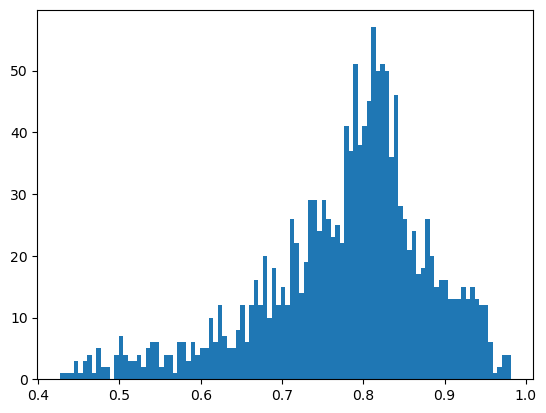

In [15]:
def calculate_fraction_in_fticr(df,group_term='parquet'):
    df = df[pd.notna(df['predicted_formula'])]
    result_true = df[df['isin_fticr_formula'] == True].groupby(group_term)['predicted_formula'].nunique()
    result_false = df[df['isin_fticr_formula'] == False].groupby(group_term)['predicted_formula'].nunique()
    combined_result = pd.concat([result_true, result_false], axis=1)
    combined_result.columns = ['formula_count_in_fticr', 'formula_count_not_in_fticr']

    combined_result.fillna(0, inplace=True)
    combined_result['fraction_formula_in_fticr'] = combined_result['formula_count_in_fticr'] / (combined_result['formula_count_in_fticr'] + combined_result['formula_count_not_in_fticr'])
    combined_result.reset_index(inplace=True,drop=False)
    
    return combined_result

formula_df = pd.read_csv('/global/homes/b/bpb/repos/scndb/data/merged_fticr_formula (2).csv')
formula_df.drop(columns=['Unnamed: 0'], inplace=True)
# Add new columns for each unique value in "environment type"
# cols = ['formula','environment_type']
# formula_df = pd.pivot_table(formula_df[cols], index='formula', columns='environment_type', aggfunc=lambda x: True, fill_value=False)
cols =  ['environment_type', 'extraction_solvent',
       'ppl_extracted', 'instrument_type',
       'mass_range', 'doi']
for c in cols:
    env = formula_df.groupby(['formula',c])['polarity'].count().unstack().fillna(0)
    env[env>0] = 1
    env.columns = ['%s:%s'%(c,x) for x in env.columns]
    env = env.astype(int)
    formula_df = formula_df.merge(env, left_on='formula', right_index=True)
    formula_df.drop(columns=c, inplace=True)
    print(c)
formula_df.drop_duplicates(subset='formula', inplace=True)
formula_df.reset_index(drop=True, inplace=True)

formula_df.drop(columns=['mz','ionization_method','polarity'],inplace=True)
all_mdm_df['isin_fticr_formula'] = all_mdm_df['predicted_formula'].isin(formula_df['formula'])

fraction_in_fticr = calculate_fraction_in_fticr(all_mdm_df)

df = pd.merge(df,fraction_in_fticr,on='parquet',how='left')
v = all_mdm_df.groupby('parquet')['isin_fticr_formula'].mean().sort_values(ascending=True)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist(v,bins=100)


In [16]:
print(all_mdm_df.shape,df.shape)
all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(v[v>0.5].index.tolist())]
df = df[df['parquet'].isin(all_mdm_df['parquet'].unique())]
print(all_mdm_df.shape,df.shape)
cols = ['formula_count_in_fticr','formula_count_not_in_fticr']
files_no_formula = df.loc[df[cols].sum(axis=1)<10,'parquet'].tolist()
df = df[~df['parquet'].isin(files_no_formula)]
all_mdm_df = all_mdm_df[all_mdm_df['parquet'].isin(df['parquet'].unique())]
print(all_mdm_df.shape,df.shape)

(777327, 14) (1506, 54)
(762680, 14) (1472, 54)
(762680, 14) (1472, 54)


# Get hits to MDM and original spectra

In [17]:
mz_tol = 0.002
# deltas = pd.read_csv(os.path.join(metadata_folder,'mdm_neutral_losses.csv'))
ref,ref2 = wt.get_p2d2(wt.mdm_df,mz_tol=mz_tol)
print(ref.shape)
ref.reset_index(inplace=True,drop=True)
ref2.reset_index(inplace=True,drop=True)
print(ref.shape)
ref_spec = ref['spectrum'].tolist()
ref_pmz = ref['precursor_mz'].tolist()

ref_spec_nl = ref2['nl_spectrum'].tolist()
ref_pmz_nl = ref2['precursor_mz'].tolist()

def score_df(df):
    min_matches=3,
    min_score=0.7,
    override_matches=20
    df.reset_index(inplace=True,drop=True)
    q_cols = ['predicted_formula','precursor_mz']
    r_cols = ['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']

    if df.shape[0]==0:
        return None
    if 'mdm_mz_vals' not in df.columns:
        return None
    df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x) if type(x)!=float else 0)

    df = df[df['num_mdm_frags']>0]


    df['mdm_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)
    df['original_spectrum'] = df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

    query_spec = df['original_spectrum'].tolist()
    query_pmz = df['precursor_mz'].tolist()
    query_spec_nl = df['mdm_spectrum'].tolist()
    query_pmz_nl = df['precursor_mz'].tolist()

    d_specs = blink.discretize_spectra(query_spec,  ref_spec, query_pmz, ref_pmz, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    d_specs_nl = blink.discretize_spectra(query_spec_nl,  ref_spec_nl, query_pmz_nl, ref_pmz_nl, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    
    def score_and_filter(specs,r,q,mz_tol=0.002,min_score=0.7,min_matches=3,override_matches=20,
                         q_cols=['predicted_formula','precursor_mz'],
                         r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name']):
        scores = blink.score_sparse_spectra(specs)
        filtered_scores = blink.filter_hits(scores,min_score=min_score,min_matches=min_matches,override_matches=override_matches,)
        mz_df = blink.reformat_score_matrix(filtered_scores)
        mz_df = blink.make_output_df(mz_df)
        for c in mz_df.columns:
            mz_df[c] = mz_df[c].sparse.to_dense()

        mz_df = pd.merge(mz_df,q[q_cols],left_on='query',right_index=True)
        mz_df = pd.merge(mz_df,r[r_cols].add_suffix('_ref'),left_on='ref',right_index=True)
        # mz_df = mz_df[mz_df['predicted_formula']==mz_df['formula']]
        mz_df = mz_df[abs(mz_df['precursor_mz']-mz_df['precursor_mz_ref'])<mz_tol]
        # mz_df.sort_values('score',ascending=False,inplace=True)
        # mz_df.drop_duplicates('inchi_key_ref',keep='first',inplace=True)
        return mz_df
    orig_hits = score_and_filter(d_specs,ref,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    nl_hits = score_and_filter(d_specs_nl,ref2,df,mz_tol=mz_tol,min_score=0.7,min_matches=3,override_matches=20,
                             q_cols=q_cols,
                             r_cols=['original_p2d2_index', 'formula','precursor_mz', 'inchi_key','name'])
    temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index_ref'],how='outer',suffixes=('_original','_mdm'))
    if temp.shape[0]==0:
        return None
    temp['max_score'] = temp[['score_original','score_mdm']].max(axis=1)
    temp['best_match_method'] = temp[['score_original','score_mdm']].idxmax(axis=1)
    temp.sort_values('max_score',ascending=False,inplace=True)
    temp = temp[temp['max_score']>min_score]  #filter on score
    temp['max_matches'] = 0
    idx = temp['best_match_method']=='score_original'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
    idx = temp['best_match_method']=='score_mdm'
    temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_mdm']
    temp = temp[temp['max_matches']>=min_matches]  #filter on matches


    cols = ['score_original','matches_original', 'score_mdm', 'matches_mdm']
    temp.drop(columns=cols,inplace=True)
    temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

    idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
    temp = temp[~idx_isolated] #filter on isolated precursor

    cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
    temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index_ref',right_on='original_p2d2_index',how='left')

    idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
    temp = temp[idx_precursor] #filter on precursor m/z
    
    # temp.sort_values('max_score',ascending=False,inplace=True)
    # temp = temp.groupby('query').head(1)
    # temp.reset_index(inplace=True,drop=True)
    return temp


# split all_mdm_df into chunks that are roughly 1000 large
chunks = np.array_split(all_mdm_df, np.ceil(len(all_mdm_df) / 1000))

def process_row(chunk):
    temp = score_df(chunk)
    return temp
    

with multiprocessing.Pool(10) as pool:
    out = pool.map(process_row, chunks)

out = pd.concat(out)
out.to_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))


(25677, 9)
(25677, 9)


In [18]:




def calculate_mass(formula):
    # Regular expression to match elements and their counts
    pattern = r'([A-Z][a-z]*)(\d*)'    
    mass = 0
    pt = rdchem.GetPeriodicTable()

    for el, count in re.findall(pattern, formula):
        # If count is an empty string, it means there's only one atom of this element
        count = int(count) if count else 1
        mass += pt.GetMostCommonIsotopeMass(el) * count
    return mass

unique_formulas = all_mdm_df['predicted_formula'].unique()
masses = {f:calculate_mass(f) for f in unique_formulas}
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_formula'].map(masses)
all_mdm_df['predicted_mass'] = all_mdm_df['predicted_mass'] - 1.007276
all_mdm_df['mass_error'] = abs(all_mdm_df['precursor_mz'] - all_mdm_df['predicted_mass'])




# there better be nothing to remove here

In [19]:
all_mdm_df.groupby('parquet')['mass_error'].median().sort_values(ascending=False).head(10)


parquet
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000088187/ccms_peak/RAW/NEG MSMS/DOM_Interlab-LCMS_lab22_A5M_NEG_MSMS_rep1.parquet              0.000768
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000087572/ccms_peak/raw data/NEG_MSMS_raw/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep2.parquet    0.000723
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v03/MSV000087572/raw/mzML/NEG_MSMS_mzML/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep2.parquet             0.000723
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/z01/MSV000087572/ccms_peak/raw data/NEG_MSMS_raw/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep1.parquet    0.000695
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v03/MSV000087572/raw/mzML/NEG_MSMS_mzML/DOM_Interlab-LC-MS_Lab20_A15M_Neg_MS2_rep1.parquet             0.000680
/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v05/MSV000091211/peak/MZ

# Merge hdf5 filename with the parquet filenames in all_mdm_df

# copy any missing hdf5 files to where they are supposed to be

In [20]:
cols=['filename','parquet']
files_df = all_mdm_df[cols].copy()
files_df.drop_duplicates(inplace=True)
files_df.reset_index(drop=True,inplace=True)
files_df['h5_missing'] = [not os.path.exists(f.replace('.parquet','.h5')) for f in files_df['parquet']]
files_to_copy = files_df[files_df['h5_missing']].copy()
files_to_copy['original_h5_missing'] = [not os.path.exists(f) for f in files_to_copy['filename']]
print(sum(files_to_copy['original_h5_missing']))
for i,row in files_to_copy.iterrows():
    parquet_file = row['parquet']
    h5_file = parquet_file.replace('.parquet','.h5')
    source_file = row['filename']
    dest_file = h5_file
    print('Copying %s to %s'%(source_file,dest_file))
    os.system('cp "%s" "%s"'%(source_file,dest_file))

all_mdm_df['h5'] = [f.replace('.parquet','.h5') for f in all_mdm_df['parquet']]


0


# Calculate the MS1 evidence for the predicted precursor in the MDM spectra

In [21]:
# FILTER OUT ANY SPECTRA THAT DO NOT HAVE MS1 OR NOT CALIBRATED WELL


def calculate_ms1_summary(row):
    """
    Calculate summary properties for features from data
    """
    d = {}
    #Before doing this make sure "in_feature"==True has already occured
    d['num_datapoints'] = row['i'].count()
    if d['num_datapoints'] == 0:
        return pd.Series(d)
    d['peak_area'] = row['i'].sum()
    idx = row['i'].idxmax()
    d['peak_height'] = row.loc[idx,'i']
    d['mz_centroid'] = sum(row['i']*row['mz'])/d['peak_area']
    d['rt_peak'] = row.loc[idx,'rt']
    return pd.Series(d)

def make_atlas(df,ppm_tolerance = 5,mz_tol = 0.002,extra_rt=1):
    atlas = df.copy()
    atlas.rename(columns={'original_index':'label','rt':'rt_peak','precursor_mz':'mz'},inplace=True)
    atlas['rt_min'] = atlas['rt_peak'] - extra_rt
    atlas['rt_max'] = atlas['rt_peak'] + extra_rt
    atlas['mz_tolerance'] = mz_tol
    atlas['ppm_tolerance'] = ppm_tolerance
    atlas['extra_time'] = 0
    atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                        stepsize=ppm_tolerance,
                                        do_ppm=True)
    return atlas




def process_row(gg):
    filename = gg[0]
    atlas = make_atlas(gg[1])
    # try:
    d = ft.get_atlas_data_from_file(filename,atlas,desired_key='ms1_neg')
    # d = d[d['in_feature']==True]
    # except:
    #     print('Can not read',filename)
    d = d.groupby('label',group_keys=True).apply(calculate_ms1_summary)
    return d


cols = ['original_index','precursor_mz',  'rt']

g = [(_,gg[cols]) for _,gg in all_mdm_df[pd.notna(all_mdm_df['h5'])].groupby('h5')]    
with multiprocessing.Pool(20) as pool:
    out = pool.map(process_row,g)    
out = pd.concat(out)

cols = ['num_datapoints','peak_area','peak_height','mz_centroid','rt_peak']
out = out[cols]


# temp = pd.merge(out,all_df[cols],left_on='label',right_on='original_index',how='inner')
# temp['ppm_error'] = abs(temp['mz_centroid']-temp['precursor_mz']) / temp['precursor_mz'] * 1e6
# temp = temp[temp['ppm_error']<5]
# temp = temp[temp['num_datapoints']>5]
# # fig,ax = plt.subplots()
# # temp['num_datapoints'].apply(np.log10).hist(bins=100,ax=ax)


# all_df = all_df[all_df.index.isin(temp['label'])]

In [22]:
out.reset_index(inplace=True,drop=False)
out.shape

(711142, 6)

In [23]:
temp = pd.merge(out.add_suffix('_ms1'),all_mdm_df,left_on='label_ms1',right_on='original_index',how='right')
print(temp.shape[0])
temp = temp[temp['num_datapoints_ms1']>2]
temp = pd.merge(temp,df,left_on='parquet',right_on='parquet',how='left')
if 'hash_value' in temp.columns:
    temp.drop(columns=['hash_value'],inplace=True)
print(temp.shape[0])

762680
692048


In [24]:
cols = ['formula_count_in_fticr','h5_x', 'h5_y','filename','redu_filename',
       'files_per_experiment', 'ms2_mz_vals',
       'ms2_i_vals','label_ms1','formula_count_in_fticr',
       'formula_count_not_in_fticr', 'fraction_formula_in_fticr']
cols = [c for c in cols if c in temp.columns]
temp.drop(columns=cols,inplace=True)
temp.to_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

In [25]:
mz_tol = 0.002
min_intensity_ratio = 2
similarity_cutoff = 0.8

# Export table of files used

In [26]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))
cols = ['parquet', 
       'experiment_id', 'massive_id',
       'title_massive', 'dataset_massive', 'description_massive',
       'instrument_massive', 'keywords_massive', 'filename_redu',
       'attribute_datasetaccession_redu', 'sampletype_redu',
       'sampletypesub1_redu', 'ncbitaxonomy_redu', 'ncbidivision_redu',
       'ncbirank_redu', 'yearofanalysis_redu', 'uberonbodypartname_redu',
       'biologicalsex_redu', 'ageinyears_redu', 'lifestage_redu',
       'country_redu', 'healthstatus_redu', 'chromatographyandphase_redu',
       'ionizationsourceandpolarity_redu', 'massspectrometer_redu',
       'sampleextractionmethod_redu', 'samplecollectionmethod_redu',
       'comorbiditylistdoidindex_redu', 'doidcommonname_redu',
       'doidontologyindex_redu', 'envoenvironmentbiome_redu',
       'depthoraltitudemeters_redu', 'humanpopulationdensity_redu',
       'internalstandardsused_redu', 'latitudeandlongitude_redu',
       'samplecollectiondateandtime_redu', 'envoenvironmentmaterial_redu',
       'envoenvironmentbiomeindex_redu', 'envoenvironmentmaterialindex_redu',
       'subjectidentifierasrecorded_redu', 'termsofposition_redu',
       'uberonontologyindex_redu', 'uniquesubjectid_redu', 'usi_redu',
       'datasource_redu']
all_spectra = all_spectra[cols]
all_spectra.drop_duplicates(subset='parquet',inplace=True)
all_spectra.reset_index(drop=True,inplace=True)
all_spectra['h5'] = [f.replace('.parquet','.h5') for f in all_spectra['parquet']]

all_spectra.to_csv(os.path.join(metadata_folder,'all_files_for_environetwork.csv'),index=False)

In [27]:
all_spectra = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_spectra.parquet'))

all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))

all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
all_spectra = pd.merge(all_spectra,all_hits[['inchi_key','max_score','original_index_query']].add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
all_spectra['max_score_identity'] = all_spectra['max_score_identity'].fillna(0)
all_spectra['inchi_key_identity'] = all_spectra['inchi_key_identity'].fillna('')
# chunk df into smaller dataframes using natural breaks in the precursor m/z greater than 0.01
all_spectra.sort_values('precursor_mz',inplace=True)
all_spectra['precursor_mz_group'] = ft.group_consecutive(all_spectra['precursor_mz'].values[:],stepsize=mz_tol,do_ppm=False)



In [28]:
all_spectra['num_mdm_frags'] = all_spectra['mdm_mz_vals'].apply(lambda x: len(x))

<Axes: >

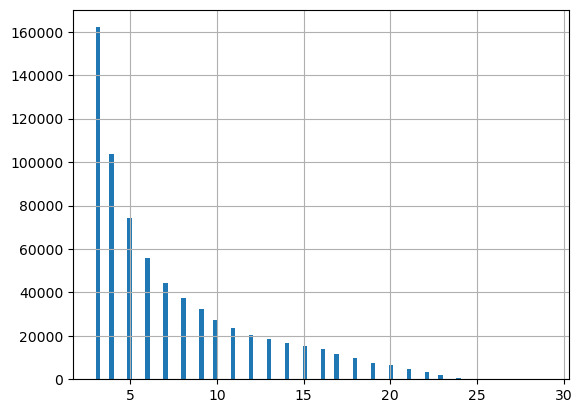

In [29]:
all_spectra['num_mdm_frags'].hist(bins=100)

# A  better way might be to start with the unique compound nodes and then add to them until you don't find any more unique!

In [30]:
import networkx as nx
def eliminate_duplicate_spectra(gg):
    ms2_df = gg[1]
    ms2_df['sum_frag_intensity'] = ms2_df['mdm_i_vals'].apply(lambda x: x.sum())
    ms2_df['max_score_identity'] = ms2_df['max_score_identity'].fillna(0)
    ms2_df['number_mdm_frags'] = ms2_df['mdm_mz_vals'].apply(lambda x: len(x))
    ms2_df.sort_values(['max_score_identity','sum_frag_intensity'],ascending=False,inplace=True) # 
    ms2_df.reset_index(inplace=True,drop=True)
    spec = ms2_df.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1).tolist()
    precursors = ms2_df['precursor_mz'].tolist()
    d_specs = blink.discretize_spectra(spec,  spec, precursors, precursors, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
    scores = blink.score_sparse_spectra(d_specs)
    similarity_matrix = scores['mzi'].todense()
    # idx = np.triu_indices(similarity_matrix.shape[0],k=0)
    # similarity_matrix[idx] = 1000
    idx_ms2similarity = similarity_matrix>similarity_cutoff
    

    pmz_diff = abs(np.subtract.outer(ms2_df['precursor_mz'].values,ms2_df['precursor_mz'].values))
    # idx = np.triu_indices(pmz_diff.shape[0],k=0)
    # pmz_diff[idx] = 1000
    idx_pmz_same = pmz_diff<mz_tol
    
    conditions = (idx_pmz_same) & (idx_ms2similarity)
    r,c = np.argwhere(conditions).T
    idx = r<c
    r = r[idx]
    c = c[idx]
    if sum(idx)==0:
        return ms2_df
    G = nx.Graph()
    G.add_edges_from([(r[i],c[i]) for i in range(len(r))])
    # draw the graph colored by subgraphs layout using spring layout
    # df = pd.DataFrame({'source':source,'target':target})
    # add the subgraph number to the dataframe
    sub_graph_indices=list(nx.connected_components(G))
    sub_graph_indices = [(i, v) for i,d in enumerate(sub_graph_indices) for k, v in enumerate(d)]
    sub_graph_indices = pd.DataFrame(sub_graph_indices,columns=['spectrum_collection','id'])
    ms2_df = pd.merge(ms2_df,sub_graph_indices,left_index=True,right_on='id',how='inner')
    ms2_df.sort_values(['max_score_identity','number_mdm_frags','sum_frag_intensity'],ascending=False,inplace=True)

    # ms2_df.drop_duplicates(['spectrum_collection','inchi_key_identity'],keep='first',inplace=True)
    ms2_df.drop_duplicates(['spectrum_collection'],keep='first',inplace=True)

    return ms2_df
    
# def eliminate_duplicate_spectra(ms2_df,preserve_unique_iks=True):
#     ms2_df['sum_frag_intensity'] = ms2_df['mdm_i_vals'].apply(lambda x: x.sum())
#     ms2_df['max_score_identity'] = ms2_df['max_score_identity'].fillna(0)
#     ms2_df.sort_values(['max_score_identity','sum_frag_intensity'],ascending=False,inplace=True) # 
#     ms2_df.reset_index(inplace=True,drop=True)
#     spec = ms2_df.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1).tolist()
#     precursors = ms2_df['precursor_mz'].tolist()
#     d_specs = blink.discretize_spectra(spec,  spec, precursors, precursors, intensity_power=0.5, bin_width=0.001, tolerance=0.01,network_score=False)#,mass_diffs=mass_diffs)
#     scores = blink.score_sparse_spectra(d_specs)
#     similarity_matrix = scores['mzi'].todense()
    
#     iks = ms2_df['inchi_key_identity'].values
#     idx_ik_same = iks[:,None] == iks
#     # idx_ik_same = idx_ik_same.astype(int)

#     has_ik = iks!=''
#     idx_has_ik = has_ik[:,None] != has_ik

#     # idx_ik_same = idx_ik_same | idx_no_ik
#     idx_ik_same_or_dominant = idx_ik_same | idx_has_ik

#     pmz_diff = abs(np.subtract.outer(ms2_df['precursor_mz'].values,ms2_df['precursor_mz'].values))
#     idx = np.triu_indices(pmz_diff.shape[0],k=0)
#     pmz_diff[idx] = 1000
    
#     frag_intensity = ms2_df['sum_frag_intensity'].values
#     intensity_diff = -1*np.subtract.outer(frag_intensity,frag_intensity)
#     intensity_diff = intensity_diff / frag_intensity[:,None]
#     idx_pmz_same = pmz_diff<mz_tol
#     idx_intensity_greater = intensity_diff>min_intensity_ratio
#     idx_ms2similarity = similarity_matrix>similarity_cutoff
    
#     # if preserve_unique_iks==True:
#     #     conditions = (idx_pmz_same) & ((idx_intensity_greater) | (idx_ms2similarity)) & (idx_ik_same_or_dominant)
#     # else:
#     # conditions = (idx_pmz_same) & ((idx_intensity_greater) | (idx_ms2similarity))
#     conditions = (idx_pmz_same) & (idx_ms2similarity)
#     r,c = np.argwhere(conditions).T
#     ms2_df = ms2_df[~ms2_df.index.isin(r)]
#     return ms2_df

# def process_row(gg):
#     return eliminate_duplicate_spectra(gg[1])

cols = ['precursor_mz','predicted_formula','original_index','mdm_mz_vals','mdm_i_vals','inchi_key_identity','max_score_identity','precursor_mz_group']
g = [(_,gg[cols]) for _,gg in all_spectra.groupby('precursor_mz_group')]
with multiprocessing.Pool(20) as pool:
    out = pool.map(eliminate_duplicate_spectra,g)
out = pd.concat(out)
idx1 = all_spectra['original_index'].isin(out['original_index'])

# # make sure to get all the spectra that have identity matches to every unique inchi key
# all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquer'))
# all_hits.sort_values('max_score',ascending=False,inplace=True)
# all_hits.drop_duplicates('inchi_key',keep='first',inplace=True)
# idx2 = all_spectra['original_index'].isin(all_hits['original_index_query'])

node_data = all_spectra[idx1]
# node_data.drop_duplicates('original_index',inplace=True)
node_data.shape

(16136, 71)

# merge in the top hit for each spectrum

In [31]:
all_hits = pd.read_parquet(os.path.join(metadata_folder,'all_environmental_identity_matches.parquet'))
all_hits.sort_values('max_score',ascending=False,inplace=True)
all_hits.drop_duplicates('original_index_query',keep='first',inplace=True)
node_data.drop(columns=['inchi_key_identity','max_score_identity','original_index_query_identity'],inplace=True)
node_data = pd.merge(node_data,all_hits.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')

In [32]:
node_data.columns

Index(['num_datapoints_ms1', 'peak_area_ms1', 'peak_height_ms1',
       'mz_centroid_ms1', 'rt_peak_ms1', 'original_index', 'precursor_mz',
       'isolated_precursor_mz', 'rt', 'coisolated_precursor_count',
       'mdm_mz_vals', 'mdm_i_vals', 'original_mz_vals', 'original_i_vals',
       'predicted_formula', 'estimated_fdr', 'parquet', 'isin_fticr_formula',
       'predicted_mass', 'mass_error', 'experiment_id', 'massive_id',
       'title_massive', 'dataset_massive', 'description_massive',
       'instrument_massive', 'keywords_massive', 'filename_redu',
       'attribute_datasetaccession_redu', 'sampletype_redu',
       'sampletypesub1_redu', 'ncbitaxonomy_redu', 'ncbidivision_redu',
       'ncbirank_redu', 'yearofanalysis_redu', 'uberonbodypartname_redu',
       'biologicalsex_redu', 'ageinyears_redu', 'lifestage_redu',
       'country_redu', 'healthstatus_redu', 'chromatographyandphase_redu',
       'ionizationsourceandpolarity_redu', 'massspectrometer_redu',
       'sampleextract

In [33]:
node_data['original_index_query_identity'].nunique(),node_data['inchi_key_identity'].nunique(),node_data.shape

(929, 829, (16136, 96))

In [34]:


node_data.reset_index(inplace=True,drop=True)
node_data['mdm_spectrum'] = node_data.apply(lambda row: np.array([row['mdm_mz_vals'],row['mdm_i_vals']]),axis=1)
node_data['original_spectrum'] = node_data.apply(lambda row: np.array([row['original_mz_vals'],row['original_i_vals']]),axis=1)
# this is where you merge in any spectra that have a identity hit
# out.reset_index(inplace=True,drop=True)
# temp = pd.concat([df,out],axis=0)
# temp.reset_index(inplace=True,drop=True)
# mass_diffs = 'no way'#[0] + deltas['mass'].tolist()
node_chunks = np.array_split(node_data, np.ceil(len(node_data) / 1000))
rem_df = []
for i,chunk in enumerate(node_chunks):
    temp_edges = wt.do_remblink_networking(chunk,node_data,mass_diffs=wt.mdm_masses,spectra_attr='mdm_spectrum')
    temp_edges.rename(columns={'rem_predicted_score':'rem_blink_score'},inplace=True)
    cols = ['ref','query','rem_blink_score']
    temp_edges = temp_edges[cols]
    temp_edges['query'] = temp_edges['query']+(i*chunk.shape[0])
    rem_df.append(temp_edges)
    

rem_df = pd.concat(rem_df)
print(rem_df.shape)


Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib


Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/repos/envnet/data/mdm_negative_random_forest.joblib
Using /global/u2/b/bpb/re

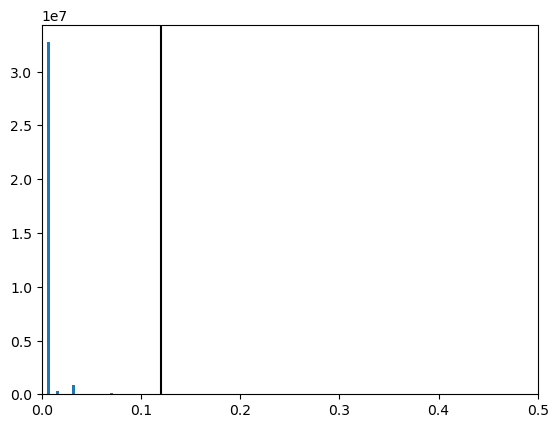

In [35]:
fig,ax = plt.subplots()
ax.hist(rem_df['rem_blink_score'],bins=200)
# ax.set_yscale('log')
ax.set_xlim(0,0.5)
ax.axvline(0.12,color='black')
plt.show()

In [36]:

rem_df = rem_df[rem_df['rem_blink_score']>0.12]
print(rem_df.shape)

(151676, 3)


In [37]:
# df.to_csv(os.path.join(metadata_folder,'calibrated_parquet_files_with_metadata.tsv'), sep='\t',index=False)

In [38]:
p = wt.get_formula_props(node_data,formula_key='predicted_formula')
node_data = pd.merge(node_data,p,left_on='predicted_formula',right_on='formula',how='left')

In [39]:
if 'original_index' in node_data.columns:
    node_data.drop(columns=['original_index'],inplace=True)
node_data.index.name = 'original_index'
node_data.reset_index(inplace=True,drop=False)


In [40]:
import networkx as nx
# # Create the graph from the similarity matrix
G_draft = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_blink_score')
G_draft.remove_edges_from([(u, v) for u, v in G_draft.edges() if u == v])         
G_draft.remove_nodes_from(list(nx.isolates(G_draft)))

G = G_draft.copy()

drop_cols = """mdm_mz_vals
mdm_i_vals
original_mz_vals
original_i_vals
mdm_spectrum
original_spectrum"""
drop_cols = drop_cols.split('\n')
cols = list(set(node_data.columns) - set(drop_cols))
node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

nx.set_node_attributes(G, node_data_dict)



In [41]:
from pyteomics import mgf

def make_mgf(output_filename,df,G,spectra_type='nl_spectrum'):
    cols = ['FEATURE_ID','SCANS','ORIGINAL_ID','PEPMASS','PRECURSOR_MZ','RTINSECONDS','CHARGE','MSLEVEL']
    temp = df[df.index.isin(G.nodes)].copy()
    temp.reset_index(inplace=True,drop=True)
    temp['FEATURE_ID'] = temp['original_index']
    temp['SCANS'] = temp.index.tolist() # probably needs +1
    temp['ORIGINAL_ID'] = temp['original_index']
    temp['CHARGE'] = '1-'
    temp['MSLEVEL'] = 2
    temp['RTINSECONDS'] = temp['rt']*60
    temp['PRECURSOR_MZ'] = temp['precursor_mz']
    temp['PEPMASS'] = temp['precursor_mz']

    spectra = []
    for i,row in temp.iterrows():
        spectra.append({'params':row[cols].to_dict(),
                        'm/z array':row[spectra_type][0],'intensity array':row[spectra_type][1]})
    mgf.write(spectra,output_filename)
    


make_mgf('../../data/envnet_mdm_spectra.mgf',node_data,G,spectra_type='mdm_spectrum')
make_mgf('../../data/envnet_original_spectra.mgf',node_data,G,spectra_type='original_spectrum')


In [42]:
from rdkit.Chem import MolFromSmiles, MolToInchiKey
smiles_col = 'smiles_identity'
# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
node_id = [k for k, v in identity_smiles.items() if isinstance(v,str)]
identity_smiles = [v for k, v in identity_smiles.items() if isinstance(v,str)]
df = pd.DataFrame(data=identity_smiles,columns=['smiles'])
df['node_id'] = node_id
df['mol'] = df['smiles'].apply(lambda x: MolFromSmiles(x) if x is not '' else None)
df['inchi_key'] = df['mol'].apply(lambda x: MolToInchiKey(x) if x is not None else None)

df

,smiles,node_id,mol,inchi_key
0,CC(O)C(=O)O,3.0,<rdkit.Chem.rdchem.Mol object at 0x7faa8bf90a50>,JVTAAEKCZFNVCJ-UHFFFAOYSA-N
1,,29.0,None,None
2,,98.0,None,None
3,,1891.0,None,None
4,,8.0,None,None
...,...,...,...,...
15090,,16131.0,None,None
15091,,16132.0,None,None
15092,,16133.0,None,None
15093,,16134.0,None,None


In [43]:
import requests
import json

url = "https://npclassifier.gnps2.org/classify"
df.reset_index(inplace=True,drop=True)
out = []
for i,row in df[pd.notna(df['inchi_key'])].iterrows(): # for some reason smiles is "" and not None
    # smiles = df.loc[0,'smiles_identity']
    r = requests.get(url, params={"smiles": row['smiles']})
    if r.status_code == 200:
        d = r.json()
    else:
        if 'C' in row['smiles']:
            print(row['smiles'])
        d = {'class_results': None,
                     'superclass_results': None,
                     'pathway_results': None,
                     'isglycoside': False}
    d['inchi_key'] = row['inchi_key']
    out.append(d)

In [44]:
out2 = pd.DataFrame(out)
cols = ['class_results', 'superclass_results', 'pathway_results']
for c in cols:
    out2[c] = out2[c].apply(lambda x: ','.join(sorted(x)) if isinstance(x,list) else '')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,JVTAAEKCZFNVCJ-UHFFFAOYSA-N
1,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,WHBMMWSBFZVSSR-UHFFFAOYSA-N
2,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,UDDSEESQRGPVIL-UHFFFAOYSA-N
4,,,Shikimates and Phenylpropanoids,False,GHMLBKRAJCXXBS-UHFFFAOYSA-N
...,...,...,...,...,...
819,Oleanane triterpenoids,Triterpenoids,Terpenoids,False,AMUBZPULDIMIKH-UGBSTRDVSA-N
820,"Flavan-3-ols,Flavanones",Flavonoids,Shikimates and Phenylpropanoids,False,PAUVEHXCLNBAPG-UHFFFAOYSA-N
821,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids,False,XHIZTTHXBFOZAS-LDYXHBNGSA-N
822,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N


In [45]:
def replace_list_identifiers(df,identifier='class_results'):
    temp = df.loc[pd.notna(df[identifier]),identifier].tolist()
    temp = [x.split(',') for x in temp]
    temp = [item for sublist in temp for item in sublist]
    temp = pd.Series(temp)
    pathway_counts = temp.value_counts()
    for i,row in df[pd.notna(df[identifier])].iterrows():
        split_results = row[identifier].split(',')
        if len(split_results) > 1:
            d = {}
            for r in split_results:
                d[r] = pathway_counts[r]
            df.at[i, identifier] = max(d, key=d.get)

    return df

out2 = replace_list_identifiers(out2,identifier='class_results')
out2 = replace_list_identifiers(out2,identifier='pathway_results')
out2 = replace_list_identifiers(out2,identifier='superclass_results')
out2

,class_results,superclass_results,pathway_results,isglycoside,inchi_key
0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,JVTAAEKCZFNVCJ-UHFFFAOYSA-N
1,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False,WHBMMWSBFZVSSR-UHFFFAOYSA-N
2,,,Shikimates and Phenylpropanoids,False,YCIMNLLNPGFGHC-UHFFFAOYSA-N
3,Dicarboxylic acids,Fatty Acids and Conjugates,Fatty acids,False,UDDSEESQRGPVIL-UHFFFAOYSA-N
4,,,Shikimates and Phenylpropanoids,False,GHMLBKRAJCXXBS-UHFFFAOYSA-N
...,...,...,...,...,...
819,Oleanane triterpenoids,Triterpenoids,Terpenoids,False,AMUBZPULDIMIKH-UGBSTRDVSA-N
820,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,PAUVEHXCLNBAPG-UHFFFAOYSA-N
821,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids,False,XHIZTTHXBFOZAS-LDYXHBNGSA-N
822,Flavanones,Flavonoids,Shikimates and Phenylpropanoids,False,YHJDRJVMBSUEDI-UHFFFAOYSA-N


In [46]:
df = pd.merge(df,out2,on='inchi_key',how='left')
df.reset_index(inplace=True,drop=True)
df

,smiles,node_id,mol,inchi_key,class_results,superclass_results,pathway_results,isglycoside
0,CC(O)C(=O)O,3.0,<rdkit.Chem.rdchem.Mol object at 0x7faa8bf90a50>,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,False
1,,29.0,None,None,NaN,NaN,NaN,NaN
2,,98.0,None,None,NaN,NaN,NaN,NaN
3,,1891.0,None,None,NaN,NaN,NaN,NaN
4,,8.0,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
15280,,16131.0,None,None,NaN,NaN,NaN,NaN
15281,,16132.0,None,None,NaN,NaN,NaN,NaN
15282,,16133.0,None,None,NaN,NaN,NaN,NaN
15283,,16134.0,None,None,NaN,NaN,NaN,NaN


In [47]:
df.drop_duplicates(inplace=True)

In [48]:
for c in ['class_results', 'superclass_results', 'pathway_results']:
    nx.set_node_attributes(G, df.set_index('node_id')[c].fillna('').to_dict(), c)


In [49]:
nx.write_graphml(G,'../../data/envnet_noprop.graphml')
# G_filt = nx.maximum_spanning_tree(G)
# nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst_noprop.graphml')

In [50]:
G = nx.read_graphml('../../data/envnet_noprop.graphml')
# main_column = 'pathway_results'
main_column = 'class_results'
all_columns = ['class_results', 'superclass_results', 'pathway_results']
df = G.nodes(data=True) 
df = pd.DataFrame(df, columns=['node_id', 'data'])
df.set_index('node_id', inplace=True)
df = df['data'].apply(pd.Series)
df.reset_index(inplace=True,drop=False)
df.head()

,node_id,precursor_mz_mdm_identity,isin_fticr_formula,formula_identity,formula_ref_mdm_identity,num_datapoints_ms1,mass_error,n,name_ref_mdm_identity,coisolated_precursor_count,formula,s,original_p2d2_index_identity,experiment_id,nosc,peak_area_ms1,predicted_formula,name_identity,precursor_mz_identity,predicted_formula_mdm_identity,mz_centroid_ms1,rt_peak_ms1,dbe_ai,smiles_identity,environmental,max_matches_identity,o_to_c,precursor_mz_query_identity,ref_mdm_identity,rt,inchi_key_ref_original_identity,original_p2d2_index_ref_identity,inchi_key_identity,h,precursor_mz_ref_mdm_identity,predicted_formula_original_identity,query_identity,original_index,inchi_key_ref_mdm_identity,p_to_c,formula_ref_original_identity,predicted_mass,original_index_query_identity,n_to_c,precursor_mz_ref_original_identity,h_to_c,dbe,name_ref_original_identity,best_match_method_identity,ai_mod,o,parquet,estimated_fdr,precursor_mz_group,coisolated_precursor_count_query_identity,peak_height_ms1,ref_original_identity,max_score_identity,c,dbe_ai_mod,precursor_mz_original_identity,plant,isolated_precursor_mz,precursor_mz,p,num_mdm_frags,class_results,superclass_results,pathway_results,description_massive,massive_id,title_massive,keywords_massive,instrument_massive,dataset_massive,ai,n_to_p
0,3.0,89.024057,False,C3H6O3,C3H6O3,216.0,0.000361,0.0,lactic acid,1,C3H6O3,0.0,21.0,SacRDelta_20240131,0.000000,1.308466e+09,C3H6O3,lactic acid,89.0244,C3H6O3,89.024269,3.928569,-2.0,CC(O)C(=O)O,True,4.0,1.000000,89.024057,18.0,4.063663,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,21.0,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,6.0,89.0244,C3H6O3,40.0,3,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,0.0,C3H6O3,89.024418,772372.0,0.0,89.0244,2.0,1.0,lactic acid,score_mdm,-0.333333,3.0,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20240212_EB_MdR_109570-002_SacRDelta_20240131_QE144_C18-EP_USDAY72369_NEG_MS2_8_soil-TasArctic-EastRivSed-PumpHouse-5gr_2_6uL_19.parquet,0.0,3,1.0,7.341887e+06,6.0,0.988503,3.0,-0.5,89.024057,False,89.024277,89.024057,0.0,3,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.0,NaN,False,NaN,NaN,322.0,0.000183,0.0,NaN,1,C4H4O4,0.0,NaN,SoilWetDry_final,1.000000,1.247363e+08,C4H4O4,NaN,NaN,NaN,115.003779,0.520319,-1.0,NaN,True,NaN,1.000000,NaN,NaN,1.133505,NaN,NaN,NaN,4.0,NaN,NaN,NaN,29,NaN,0.0,NaN,115.003683,NaN,0.0,NaN,1.0,3.0,NaN,NaN,0.500000,4.0,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_12_P12-Control_2_Rg80to1200-CE102040-soil-Ultisol-S1_Run106.parquet,0.0,23,NaN,1.051995e+06,NaN,NaN,4.0,1.0,NaN,False,115.003784,115.003500,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,98.0,NaN,False,NaN,NaN,75.0,0.000217,0.0,NaN,1,C5H4O5,0.0,NaN,SoilWetDry_final,1.200000,2.359615e+06,C5H4O5,NaN,NaN,NaN,142.998748,11.421476,-1.0,NaN,True,NaN,1.000000,NaN,NaN,11.128962,NaN,NaN,NaN,4.0,NaN,NaN,NaN,98,NaN,0.0,NaN,142.998597,NaN,0.0,NaN,0.8,4.0,NaN,NaN,0.600000,5.0,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/metatlas/20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_QE-HF_C18_USDAY63680_NEG_MSMS_32_SC-Control_2_Rg80to1200-CE102040-soil-Oxisol-S1_Run82.parquet,0.0,71,NaN,7.704354e+04,NaN,NaN,5.0,1.5,NaN,False,143.035049,142.998381,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1891.0,NaN,False,NaN,NaN,7.0,0.000556,6.0,NaN,1,C3H6N6O2S2,2.0,NaN,MSV000088823,6.666667,2.609452e+06,C3H6N6O2S2,NaN,NaN,NaN,220.992618,1.850846,-6.0,NaN,True,NaN,0.666667,NaN,NaN,1.757335,NaN,NaN,NaN,6.0,NaN,NaN,NaN,1891,NaN,0.0,NaN,220.992089,NaN,2.0,NaN,2.0,4.0,NaN,NaN,0.833333,2.0,/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive/v04/MSV000088823/updates/2022-02-16_bciap01_2e2457db/peak/Peaks/mzmL/MS2_Neg_mode/DOM_Interlab-LCMS_Lab8_A45M_Neg_MS2_rep1.parquet,0.0,979,NaN,1.751928e+06,NaN,NaN,3.0,-5.0,NaN,False,221.066345,220.992646,0.0,4,NaN,NaN,NaN,"Interlab Study of LC-MS/MS analyis of Marine Dissolved Organic Matter from SIO Pietr (

In [51]:

# def get_most_common(classes):
#     class_counts = Counter(classes)
#     # Get the most common string
#     most_common_class = class_counts.most_common(1)[0][0]
#     return most_common_class

# classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
# superclass_name = []
# class_name = []
# subclass_name = []
# iks = df.loc[pd.notna(df['inchi_key']),'inchi_key'].unique()
# for ik in iks:
#     f = '%s.json'%ik
#     f = os.path.join(classyfire_dir,f)
#     with open(f,'r') as fid:
#         cf = fid.read()
#     cf = json.loads(cf.strip())
#     if isinstance(cf,str):
#         cf = json.loads(cf)
#     # cf_json = json.dumps(cf)
#     if not main_column in cf:
#         cf[main_column] = {'name':None}
#     if not 'superclass' in cf:
#         cf['superclass'] = {'name':None}
#         cf['class'] = {'name':None}
#     if cf[main_column] is None:
#         cf[main_column] = {'name':None}
#     superclass_name.append(cf['superclass']['name'])
#     class_name.append(cf['class']['name'])
#     subclass_name.append(cf[main_column]['name'])

# temp = pd.DataFrame(index=iks)
# temp['superclass'] = superclass_name
# temp['class'] = class_name
# temp[main_column] = subclass_name

# df = pd.merge(df,temp,left_on='inchi_key',right_index=True,how='left')

# df

In [52]:
df.loc[df['node_id']=='41.0',all_columns]

,class_results,superclass_results,pathway_results
51,NaN,NaN,NaN


In [53]:

def min_additional_subgraph(graph, original_nodes,radius=1,min_count=0):
    nodes = []
    for node in original_nodes:
        # Create an ego graph centered at the current node
        
        ego_subgraph = nx.ego_graph(graph, node,radius=radius)
        nodes.extend(list(ego_subgraph.nodes))
    df = pd.DataFrame(data=nodes,columns=['nodes'])
    df = df.groupby('nodes').filter(lambda x: len(x) >= min_count)
    nodes = df['nodes'].tolist() + original_nodes
    
    nodes = list(set(nodes))
    nodes = sorted(nodes)
    return nodes

sc_df = pd.DataFrame()
sc_df['node_id'] = df['node_id'].values
sc_df[main_column] = df[main_column].values
for class_name in sc_df.loc[pd.notna(sc_df[main_column]),main_column].unique():
    idx = sc_df[main_column]==class_name
    original_nodes = sc_df.loc[idx,'node_id'].tolist()
    new_nodes = min_additional_subgraph(G, original_nodes,radius=2,min_count=3)
    sc_df[class_name] = False
    # idx = sc_df['node_id'].isin(original_nodes)
    # sc_df.loc[idx,class_name] = True
    idx = sc_df['node_id'].isin(new_nodes)
    sc_df.loc[idx,class_name] = True
sc_df.set_index('node_id',inplace=True)
sc_df.drop(columns=[main_column],inplace=True)
sc_df
# For each row in the DataFrame
# If the sum of the row is greater than 1
# Find the class with the highest frequency
# Set all other classes to False

,Hydroxy fatty acids,Dicarboxylic acids,4-pyrone derivatives,Unsaturated fatty acids,Simple phenolic acids,Branched fatty acids,Wax monoesters,Simple coumarins,Cinnamic acids and derivatives,Menthane monoterpenoids,Acyclic monoterpenoids,Aminoacids,Shikimic acids and derivatives,Dipeptides,Oxo fatty acids,Phenanthrenes,2-pyrone derivatives,Monosaccharides,Chromones,Phenylethylamines,Arylnaphthalene and aryltetralin lignans,Quinoline alkaloids,Phthalide derivatives,Naphthalenones,Open-chain polyketides,Isocoumarins,Catechols with side chains,Jasmonic acids,Simple cyclic polyketides,Pinane monoterpenoids,Pyridine alkaloids,Quinazoline alkaloids,Germacrane sesquiterpenoids,Naphthoquinones,Flavones,Camphane monoterpenoids,Sorbicilinoids,Methyl xanthones,Azaphilones,Iridoids monoterpenoids,Simple indole alkaloids,pteridine alkaloids,Acyl phloroglucinols,Caryophyllane sesquiterpenoids,Monomeric stilbenes,Fungal DPEs,Flavanones,Humulane sesquiterpenoids,Flavonols,Prenyl quinone meroterpenoids,Phenazine alkaloids,Quadrane sesquiterpenoids,Pulvinones,Chalcones,Anthraquinones and anthrones,Pyrrolidine alkaloids,Picrotoxane sesquiterpenoids,Isoindole alkaloids,Apocarotenoids(ε-),Zearalenones,Macrolide lactones,Iphionane sesquiterpenoids,Cadinane sesquiterpenoids,Heterocyclic fatty acids,Aurones,Isoflavones,Gallotannins,Dihydroflavonols,Furans,Podocarpane diterpenoids,Guaiane sesquiterpenoids,Eudesmane sesquiterpenoids,Neolignans,Pyranocoumarins,Cannabinoids,Phenylalanine-derived alkaloids,Gibberellins,Flavan-3-ols,12-oxophytodienoic acid metabolites,Depsidones,Pterocarpan,N-acyl amines,Isoflavanones,Bisabolane sesquiterpenoids,Other Octadecanoids,Linear diarylheptanoids,Colensane and Clerodane diterpenoids,Estrane steroids,Prezizaane sesquiterpenoids,Cembrane diterpenoids,Pseudoguaiane sesquiterpenoids,Pimarane and Isopimarane diterpenoids,Leukotrienes,Prostaglandins,Angucyclines,Furanoid lignans,Abietane diterpenoids,Dibenzylbutane lignans,Coumestan,Phytoprostanes,Abeoabietane diterpenoids,Serrulatane and Biflorane diterpenoids,Hydroxy-hydroperoxyeicosapentaenoic acids,Hydroxy-hydroperoxyeicosatetraenoic acids,Hydroxy-hydroperoxyeicosatrienoic acids,Labdane diterpenoids,Paraconic acids and derivatives,Nitro fatty acids,Usnic acid and derivatives,Miscellaneous apocarotenoids,Phytofurans,Other Docosanoids,Pregnane steroids,Arteminisin,Thromboxanes,p-Terphenyls,Biaryl type diarylheptanoids,Androstane steroids,Isoquinoline alkaloids,Maresins,Polyprenylated cyclic polyketides (Hop meroterpenoids),Resolvin Ds,Plant xanthones,Grayanotoxane diterpenoids,Furofuranoid lignans,Daucane sesquiterpenoids,Fatty alcohols,Cardenolides,Kaurane and Phyllocladane diterpenoids,Diarylether type diarylheptanoids,Depsides,Cholane steroids,Pachydictyane diterpenoids,Tetraketide meroterpenoids,3-Decalinoyltetramic acids,Cholestane steroids,Oligomeric stibenes,Ansa macrolides,Oleanane triterpenoids,Farnesane sesquiterpenoids,Lupane triterpenoids,Erythromycins,Ergostane steroids,Lanostane,Ursane and Taraxastane triterpenoids,Fusidane triterpenoids
node_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [54]:
# for columns with more than one True value, get the regional value_counts from an ego graph of radius 5 and replace with the most common value
for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
    ego_subgraph = nx.ego_graph(G, i,radius=1) #was 5
    nodes = list(ego_subgraph.nodes)
    temp = sc_df.loc[nodes]
    temp = temp.sum()
    temp = temp[temp>0]
    if len(temp)>0:
        most_common_class = temp.idxmax()
        sc_df.loc[i] = False
        sc_df.loc[i,most_common_class] = True



In [55]:
# # make a list of the classes that are most common
# ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)
# # for nodes that are in more than one class, only keep the most abundant class
# for i,row in sc_df[sc_df.sum(axis=1)>1].iterrows():
#     # get the most commonly occuring class
#     keep_class = ranked_frequency[row[row==True].index].sort_values(ascending=False).index[0]
#     # get the indices of all the assigned classes
#     idx = row[row==True].index
#     # drop all but the most common
#     idx = idx[idx!=keep_class]
#     # zero them out
#     sc_df.loc[i,idx] = False

In [56]:
# for any class that has an ID in the original, reset it back to its original state
for i,row in df.iterrows():
    if pd.notna(row[main_column]):
        sc_df.loc[row['node_id'],:] = False
        sc_df.loc[row['node_id'],row[main_column]] = True


# recomute the ranked frequency now that ambiguous classes have been resolved
ranked_frequency = sc_df.sum(axis=0).sort_values(ascending=False)

In [57]:
cols = sc_df.columns
sc_df = sc_df.reset_index().melt(id_vars='node_id',value_vars=cols)
idx = sc_df['value']==True
sc_df = sc_df[idx]
sc_df = sc_df[pd.notna(sc_df['variable'])]
sc_df


,node_id,variable,value
0,3.0,Hydroxy fatty acids,True
3,1891.0,Hydroxy fatty acids,True
8,1442.0,Hydroxy fatty acids,True
11,11.0,Hydroxy fatty acids,True
38,994.0,Hydroxy fatty acids,True
...,...,...,...
2187400,14130.0,Ursane and Taraxastane triterpenoids,True
2187608,14500.0,Ursane and Taraxastane triterpenoids,True
2187614,14505.0,Ursane and Taraxastane triterpenoids,True
2187946,15079.0,Ursane and Taraxastane triterpenoids,True


In [58]:
sc_df.value_counts('variable').head(40)

variable
Simple coumarins                        1533
Zearalenones                             684
Gibberellins                             587
Aminoacids                               472
Chalcones                                461
Prostaglandins                           362
Tetraketide meroterpenoids               353
Dicarboxylic acids                       263
Simple phenolic acids                    242
Cinnamic acids and derivatives           211
Isoflavones                               92
Oleanane triterpenoids                    82
Cannabinoids                              81
Methyl xanthones                          67
Abietane diterpenoids                     61
Cadinane sesquiterpenoids                 34
Cholane steroids                          27
Flavonols                                 26
Flavones                                  22
Other Octadecanoids                       22
Flavanones                                21
Hydroxy fatty acids                       21
C

In [59]:
sc_df

,node_id,variable,value
0,3.0,Hydroxy fatty acids,True
3,1891.0,Hydroxy fatty acids,True
8,1442.0,Hydroxy fatty acids,True
11,11.0,Hydroxy fatty acids,True
38,994.0,Hydroxy fatty acids,True
...,...,...,...
2187400,14130.0,Ursane and Taraxastane triterpenoids,True
2187608,14500.0,Ursane and Taraxastane triterpenoids,True
2187614,14505.0,Ursane and Taraxastane triterpenoids,True
2187946,15079.0,Ursane and Taraxastane triterpenoids,True


In [60]:
# Add cluster labels to graph
cluster_dict = sc_df.copy()
cluster_dict.rename(columns={'variable':'structural_cluster_subclassname'},inplace=True)
print(cluster_dict.shape)
if main_column != 'pathway_results':
    cluster_dict = pd.merge(df[all_columns].drop_duplicates(main_column),cluster_dict,left_on=main_column,right_on='structural_cluster_subclassname',how='right')
else:
    cluster_dict[main_column] = cluster_dict['structural_cluster_subclassname']

cluster_dict.drop(columns=['structural_cluster_subclassname','value'],inplace=True)
cluster_dict.drop_duplicates('node_id',inplace=True)
cluster_dict.set_index('node_id',inplace=True)
cluster_dict.fillna('',inplace=True)
cluster_dict = cluster_dict.add_suffix('_propagated')

cluster_dict

(6095, 3)


,class_results_propagated,superclass_results_propagated,pathway_results_propagated
node_id,,,
3.0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids
1891.0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids
1442.0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids
11.0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids
994.0,Hydroxy fatty acids,Fatty Acids and Conjugates,Fatty acids
...,...,...,...
14130.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids
14500.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids
14505.0,Ursane and Taraxastane triterpenoids,Triterpenoids,Terpenoids


In [61]:
print(cluster_dict.shape)
# need to understand why there are duplicates

cluster_dict = cluster_dict.to_dict(orient='index')

nx.set_node_attributes(G, cluster_dict)
# cluster_dict
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# len(clusters),len(set(clusters))

(6095, 3)


In [62]:
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)
df.value_counts('pathway_results')

pathway_results
Shikimates and Phenylpropanoids    284
Fatty acids                        163
Terpenoids                         151
Polyketides                         96
Amino acids and Peptides            43
Alkaloids                           40
Carbohydrates                        5
dtype: int64

In [63]:
df.value_counts('pathway_results_propagated')

pathway_results_propagated
Shikimates and Phenylpropanoids    2762
Terpenoids                         1335
Polyketides                         765
Fatty acids                         723
Amino acids and Peptides            477
Alkaloids                            25
Carbohydrates                         8
dtype: int64

In [64]:
# df = G.nodes(data=True)
# df = pd.DataFrame(df)
# df.columns = ['node','data']
# df['data'] = df['data'].apply(lambda x: dict(x))
# df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
# df.reset_index(inplace=True,drop=True)
# df['consensus_class'] = None

# # Count the number of occurrences of each subclass
# subclass_counts = df[main_column].value_counts()

# # Get the subclasses that have at least 100 values
# large_subclasses = subclass_counts[subclass_counts >= 100].index

# # Set the consensus_class for large subclasses
# df.loc[df[main_column].isin(large_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(large_subclasses), main_column]

# # Get the subclasses that have less than 100 values
# small_subclasses = subclass_counts[subclass_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df[main_column].isin(small_subclasses), 'consensus_class'] = df.loc[df[main_column].isin(small_subclasses), 'class']

# # Get the subclasses that have less than 100 values
# class_counts = df['consensus_class'].value_counts()
# small_classes = class_counts[class_counts < 100].index

# # Set the consensus_class for small subclasses
# df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

# df = df[['node','consensus_class']]

# df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

# df.fillna('',inplace=True)
# df.value_counts('consensus_class')
# nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


In [65]:
# import os
# import networkx as nx
# from pathlib import Path
# try:
#     module_path = os.path.join(Path(__file__).parents[2])
# except: # Jupyter notebook probably
#     module_path = os.path.join(os.getcwd(), '../../')
# graphml_file = os.path.join(module_path, 'data/CarbonNetwork.graphml')
# G = nx.read_graphml(graphml_file)


In [66]:
# nx.write_graphml(G,'/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork.graphml')
# G_filt = nx.maximum_spanning_tree(G)
# nx.write_graphml(G_filt, '/global/cfs/cdirs/metatlas/projects/carbon_network/CarbonNetwork_mst.graphml')
print('nodes',len(G.nodes))
print('edges',len(G.edges))

nx.write_graphml(G,'../../data/envnet.graphml')

# get the edge data from T and store it as a data from with "source" and "target" and "weight" attributes
edge_data = nx.to_pandas_edgelist(G)
edge_data['source'] = edge_data['source'].astype(float).astype(int)
edge_data['target'] = edge_data['target'].astype(float).astype(int)
edge_data = edge_data[['source','target']]
edge_data.to_csv('../../data/edge_data.csv',index=None)

# get the node data from T and store it as a data from with "node" and "data" attributes
node_data = G.nodes(data=True)
node_data = pd.DataFrame(node_data)
node_data.columns = ['node','data']
node_data['data'] = node_data['data'].apply(lambda x: dict(x))
node_data = pd.concat([node_data.drop(['data'], axis=1), node_data['data'].apply(pd.Series)], axis=1)
node_data.to_csv('../../data/node_data.csv',index=None)

# https://cosmograph.app/run/?data=https://raw.githubusercontent.com/benbowen/thoughts/master/edge_data.csv



nodes 15095
edges 143337


In [67]:
# # Create a maximum spanning tree from G
# T = nx.maximum_spanning_tree(G, weight='rem_blink_score')

# # Get the list of edges in G sorted by weight in descending order
# edges_sorted_by_weight = sorted(G.edges(data=True), key=lambda x: x[2]['rem_blink_score'], reverse=True)
# max_degree = 3
# # Add edges back to the tree from the original network until there are 30000 edges total in the network
# for u, v, data in edges_sorted_by_weight:
#     if T.number_of_edges() >= 350000:
#         break
#     # check the degree of the nodes
#     if T.degree(u) > max_degree:
#         continue
#     if T.degree(v) > max_degree:
#         continue
#     if not T.has_edge(u, v):
#         T.add_edge(u, v, **data)
    

# print('nodes', len(T.nodes))
# print('edges', len(T.edges))

# # G.remove_nodes_from(list(nx.isolates(G)))
# # k = 5  # replace with your desired k

# # from blink.utils import filter_top_k
# # # filter_top_k(G, top_k=k, edge_score='rem_blink_score')



# # drop_cols = """mdm_mz_vals
# # mdm_i_vals
# # original_mz_vals
# # original_i_vals
# # mdm_spectrum
# # original_spectrum"""
# # drop_cols = drop_cols.split('\n')
# # cols = list(set(node_data.columns) - set(drop_cols))

# # node_data_dict = node_data[cols].fillna('').to_dict(orient='index')

# # nx.set_node_attributes(T, node_data_dict)
# # # Remove self-loops
# # Remove isolates
# T.remove_nodes_from(list(nx.isolates(T)))
# print('nodes',len(T.nodes))
# print('edges',len(T.edges))
# nx.write_graphml(T,'../../data/CarbonNetwork.graphml')
# # nx.write_graphml(G,'CarbonNetwork.graphml')


In [68]:
# edges_sorted_by_weight[40000]

NameError: name 'edges_sorted_by_weight' is not defined

In [ ]:

# this will stop the run
# # import networkx as nx

# # # Get the connected components in the graph
# components = list(nx.connected_components(G))

# # # Filter out subgraphs with less than 1000 nodes
# filtered_components = [component for component in components if len(component) >= 1000]

# # # Create a new graph
# G_filtered = nx.Graph()

# # # Add each subgraph to the new graph
# for component in filtered_components:
#     G_filtered = nx.compose(G_filtered, G.subgraph(component))
    
# # alg = 'sfdp'

# # do it like this
# # pos = graphviz_layout(G, prog='dot', root=0, args='-Grankdir="LR"')

# alg = 'neato'
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="scale"')
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="False"') #blob
# # pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="vpsc"') #crashes
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="orthoxy"') #looks like a lightning bolt
# pos = nx.nx_agraph.graphviz_layout(G_filtered, prog=alg,args='-Goverlap="ipsep"') #looks like 
# ipsep

# for node, (x, y) in pos.items():
#     G_filtered.nodes[node]['x'] = x
#     G_filtered.nodes[node]['y'] = y

# nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions.graphml'))


In [ ]:
# import matplotlib.pyplot as plt
# nx.draw(G_filtered, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=3)

# plt.show()

In [ ]:
# # remove node overlaps
# pos = nx.kamada_kawai_layout(G_filtered)
# for node, (x, y) in pos.items():
#     G_filtered.nodes[node]['x'] = x
#     G_filtered.nodes[node]['y'] = y
# nx.write_graphml(G_filtered, graphml_file.replace('.graphml', '_with-positions_kamada-kawai.graphml'))